In [92]:
from IPython.core.debugger import set_trace # 调试工具
import pandas as pd
import numpy as np
import torch
import time
from torch import nn
data = pd.read_excel('多步预测建模数据.xlsx')

### 定义数据

In [106]:
def mean(data):
    return data.mean()
def std(data):
    return data.std()
# 解析数据,采样周期40s
data40 = np.array(data.iloc[0:-1:2,1:])
Load = data40[:,0] 
O2 = data40[:,1]
FuelAF = data40[:,2:8]
SecA = data40[:,8]
SecB = data40[:,9]
SecC = data40[:,10]
SecD = data40[:,11]
SecE = data40[:,12]
SecF = data40[:,13]
Sofah = data40[:,14]
Sofaq = data40[:,15]
NOx = data40[:,17]  # 滤波后的NOx
Sofa = (Sofah + Sofaq)/2  # sofa风合并
SecCF = (SecC + SecF)/2  # 二次风中层CF合并
SecBE = (SecB + SecE)/2  # 二次风下层BE合并

# 对数据归一化到[0,1] 
NOx_max = 650
NOx_min = 200
# NOx = (NOx - NOx_min)/(NOx_max - NOx_min)
NOx = NOx
Load = (Load - mean(Load))/std(Load)
O2 = (O2 - mean(O2))/std(O2)
FuelAF = (FuelAF - np.mean(FuelAF,0))/np.std(FuelAF,0)

SecA = (SecA - mean(SecA))/std(SecA)
SecD = (SecD - mean(SecD))/std(SecD)
SecCF = (SecCF - mean(SecCF))/std(SecCF)
SecBE = (SecBE - mean(SecBE))/std(SecBE)
Sofa = (Sofa- mean(Sofa))/std(Sofa)
variables = np.zeros((len(NOx),13))
variables[:,0] = O2
variables[:,1:7] = FuelAF
variables[:,7] = SecA
variables[:,8] = SecD
variables[:,9] = SecCF
variables[:,10] = SecBE
variables[:,11] = Sofa
variables[:,12] = NOx
print(variables.shape)

(26214, 13)


### 构建样本集合

In [122]:
Len = 9100; # 建模用数据长度
st = 100
ed = st+Len
Y = NOx[st:ed].reshape(-1,1)
delays = [1,1,1,1,1,1,1,1,1,1,1,1,1] # 共计13个变量，每个变量的迟延时间
orders = [1,1,1,1,1,1,1,1,1,1,1,1,1]    # 共计13个变量，每个变量的输入阶数
#delays = [1,3,3,3,2,3,5,3,3,2,4,10,1]  # 共计13个变量，每个变量的迟延时间
#orders = [3,5,4,5,6,5,5,1,5,6,6,3,4]    # 共计13个变量，每个变量的输入阶数
X = np.zeros((Len,sum(orders)))
count = 0;
for i in range(13):
    delay = delays[i]
    order = orders[i]
    for j in range(order):
        X[:,count] = variables[st-delay-j:ed-delay-j,i]
        count += 1
print(f'X维度{X.shape},Y维度{Y.shape}')
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)


def Split(X, Y, test_size=0.25):
    train_num = int(len(X)*(1-test_size))
    X_train = X[:train_num,]
    y_train = Y[:train_num,]
    X_test = X[train_num:,]
    y_test = Y[train_num:,]
    return X_train, X_test, y_train, y_test

import random

def random_iter(x_train, y_train, batch_size, enc_time_step, dec_time_step, stride):
    global seed
    random.seed(seed)
    offset = random.randint(0, stride)  # 随机开始
    initial_indices = (np.arange(offset, len(x_train) - enc_time_step - dec_time_step, stride))  # 样本开始索引
    random.shuffle(initial_indices)  # 随机打断样本开始索引

    # 注意的是，y_train值已经前向推进了一步
    def data(pos, sign):
        if sign == 1:
            return x_train[pos:pos + enc_time_step]
        if sign == 2:
            x_dec = x_train[pos + enc_time_step:pos + enc_time_step + dec_time_step].clone()
            # 第一维保持不变    # dec中氧量保持常数
            x_dec[1:, 0] = x_dec[0, 0]
            return x_dec
        if sign == 3:
            return y_train[pos + enc_time_step:pos + enc_time_step + dec_time_step]

    num_batches = len(initial_indices) // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        x_enc = torch.stack([data(j, 1) for j in initial_indices_per_batch])
        x_dec = torch.stack([data(j, 2) for j in initial_indices_per_batch])
        y = torch.stack([data(j, 3) for j in initial_indices_per_batch])
        # 对 NOx 归一化 仅batch
        nox_mean = x_enc[:, :, -1].mean(1)
        nox_std = x_enc[:, :, -1].std(1)
        
        x_enc[:, :, -1] = (x_enc[:, :, -1] - nox_mean.reshape(-1, 1))/nox_std.reshape(-1, 1)
        x_dec[:, :, -1] = (x_dec[:, :, -1] - nox_mean.reshape(-1, 1))/nox_std.reshape(-1, 1)
        y = (y - nox_mean.reshape(-1, 1, 1))/nox_std.reshape(-1, 1, 1)
        yield x_enc, x_dec, y, (nox_mean, nox_std)


class RandomDataLoader:
    def __init__(self, x_train, y_train, batch_size, enc_time_step, dec_time_step, stride):
        self.x_train, self.y_train = x_train, y_train
        self.batch_size = batch_size
        self.enc_time_step, self.dec_time_step, self.stride = enc_time_step, dec_time_step, stride

    def __iter__(self):
        return random_iter(self.x_train, self.y_train, self.batch_size,
                                self.enc_time_step, self.dec_time_step, self.stride)

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# 随机种子
seed = 45
seed_everything(seed)
#X = X.unsqueeze(axis=1)
X_train, X_test, y_train, y_test = Split(X, Y, test_size=0.2)
X_train, X_val, y_train, y_val = Split(X_train, y_train, test_size=0.3)

print(f'X_train.shape: {X_train.shape}, X_val.shape:{X_val.shape}, X_test.shape:{X_test.shape}')
batch_size = 128
encoder_len = 20
decoder_len = 15
stride = 1
train_dl = RandomDataLoader(X_train, y_train, batch_size, encoder_len, decoder_len, stride)
val_dl = RandomDataLoader(X_val, y_val, batch_size, encoder_len, decoder_len, stride)
test_dl = RandomDataLoader(X_test, y_test, batch_size, encoder_len, decoder_len, stride)

X维度(9100, 13),Y维度(9100, 1)
X_train.shape: torch.Size([5096, 13]), X_val.shape:torch.Size([2184, 13]), X_test.shape:torch.Size([1820, 13])


In [10]:
# for x_enc, x_dec, y, normlizer in train_dl:
#     print(x_enc.shape, x_dec.shape, y.shape)
#     print(x_dec[0, :, -1])
#     print(x_enc[0, :, -1])
#     print(y[0, :, -1])   
# # 对 nox 做 batch norm预测时处理

### 定义模型

In [123]:
class RNNModel(nn.Module):
    def __init__(self, feature_size):
        super().__init__()
        self.rnn = nn.LSTM(input_size=feature_size, hidden_size=32, num_layers=2, dropout=0.1)
        self.feature_size = feature_size
        self.num_hiddens = self.rnn.hidden_size
        self.num_directions = 1  # 单向
        
        self.val_loss_list = []
        self.train_loss_list = []
        self.min_loss = 1e6
        self.val_multi_step_loss_list = []  # 验证集每个epoch 多步loss  mean
        self.min_multi_step_loss = 1e6  # 再训练评价指标

        self.fc = nn.Sequential(
            nn.Linear(self.num_hiddens * self.num_directions, 16),
            nn.Linear(16, 1))
        
    def encode(self, x_enc):
        # LSTM state为元组形式，包括(h0,c0)
        # x为[时间步, batch_size, feature_szie]
        # RNN 返回为(L,N,D*H_out)
        _, state = self.rnn(x_enc)
        return state
        
    def decode(self, x_dec, state):
        H, state = self.rnn(x_dec, state)
        y_hat = self.fc(H.reshape((-1, H.shape[-1])))
        return y_hat, state

    def forward(self, x_enc, x_dec):
        # LSTM state为元组形式，包括(h0,c0)
        # x为[时间步, batch_size, feature_szie]
        # RNN 返回为(L,N,D*H_out)
        # encoder
        state = self.encode(x_enc)
        # decoder
        y_hat,_ = self.decode(x_dec, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,1)。
        return y_hat
    
    def predict(self ,x_enc, x_dec):
        # batch归一化后的值，时间步，batch，features
        # batch归一化后的值，时间步，batch，features
        y = []
        with torch.no_grad():
            self.eval()
            # 迭代多步，并且每次预测值替换x_dec中的真实值
            state = self.encode(x_enc)
            y_hat, state = self.decode(x_dec[0, :, :].reshape(1, 1, -1), state)
            y.append(y_hat)
            for i in range(1, x_dec.shape[0]):
                # 预测值替换, 获得下一步的decode输入
                x_dec_next = x_dec[i, :, :].clone().reshape(1, 1, -1)
                x_dec_next[...,-1] = y_hat
                # 氧量不变已经处理过
                y_hat, state = self.decode(x_dec_next.reshape(1, 1, -1), state)
                y.append(y_hat)
        return torch.cat(y)
               
        

# 评价测试集
def evaluate_mae(data_iter, net, state=None, device=None):
    net.eval()
    if device is None:
        device = list(net.parameters())[0].device
    mae_sum, n = 0.0, 0

    with torch.no_grad():
        for x_enc, x_dec, y, normlizer in data_iter:
            # x[batch_size,time_step,features]  y[batch_size,time_step,1]
            x_enc.transpose_(0, 1)
            x_dec.transpose_(0, 1)
            y.transpose_(0, 1)
            x_enc = x_enc.to(device)
            x_dec = x_dec.to(device)
            y = y.to(device)
       
            y_hat = net(x_enc, x_dec)  # 输出的y_hat(时间步数*批量大小,1) state(D∗num_layers,N,H)
            mae_sum += (torch.abs(y_hat.reshape(-1) - y.reshape(-1)) * normlizer[1].repeat(15)).sum().cpu().item()
            n += y.numel()
    return mae_sum / n

def call_save_model(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/DeepAR.pth")
        print(f'call:{val_loss}')
    
def call_early_stop(net, val_loss):
    if val_loss < net.min_loss:
        net.min_loss = val_loss
        torch.save(net.state_dict(), "model/DeepAR.pth")
        print(f'call:{val_loss}')
        net.early_stop_sign = 0
    else:
        net.early_stop_sign += 1
        
    if net.early_stop_sign >= 20:
        return True
    else:
        return False

# 训练模型
def train_net(net, train_iter, test_iter, optimizer, loss, device, epochs):
    
    net = net.to(device)
    test_mae_list = net.val_loss_list  
    test_multi_step_loss_list = net.val_multi_step_loss_list  # 验证集每个epoch多步loss, 进行迭代多步
    train_mae_list = net.train_loss_list
    
    for epoch in range(1, epochs + 1):
        state = None
        train_l_sum, train_mae_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for x_enc, x_dec, y, normlizer in train_iter:
            # x[batch_size,time_step,features]  y[batch_size,time_step,1]
            x_enc.transpose_(0, 1)
            x_dec.transpose_(0, 1)
            y.transpose_(0, 1)
            x_enc = x_enc.to(device)
            x_dec = x_dec.to(device)
            y = y.to(device)
 
            net.train()
            y_hat = net(x_enc, x_dec)  # 输出的y_hat(时间步数*批量大小,1) state(D∗num_layers,N,H)
            l = loss(y_hat.reshape(-1), y.reshape(-1))
             
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            with torch.no_grad():
                train_l_sum += l.cpu().item()
                train_mae_sum += (torch.abs(y_hat.reshape(-1) - y.reshape(-1)) * normlizer[1].repeat(15)).sum().cpu().item()
                n += y.numel()

        # y_pred, y_true = IterMutilStep(X_val, y_val, net, horizon=15, device=device) # 迭代多步
        test_mae = evaluate_mae(test_iter, net, device)  # 均值MAE
        test_mae_list.append(test_mae)
        train_mae_list.append(train_mae_sum/n) 

        # 每次决定是否保存模型
        # call_save_model(net,  test_mae)
        early_stop = call_early_stop(net, test_mae)
        if early_stop:
            break
        # 展示
        print('epoch %d, loss %.4f, trian_mae %.3f, test_mae %.3f, time %.2f sec'
              % (epoch, train_l_sum/n, train_mae_sum/n, test_mae, time.time() - start))
                
        net.val_loss_list = test_mae_list
        net.val_multi_step_loss_list = test_multi_step_loss_list
        net.train_loss_list = train_mae_list
        torch.save(torch.tensor(net.val_loss_list), "loss/DeepAR_val_loss.pt")
        torch.save(torch.tensor( net.val_multi_step_loss_list), "loss/DeepAR_val_multi_step_loss.pt")
        torch.save(torch.tensor(net.train_loss_list), "loss/DeepAR_train_loss.pt")

In [124]:
import os
np.random.seed(seed) 
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)  # 禁止hash随机化
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # 在cuda 10.2及以上的版本中，需要设置以下环境变量来保证cuda的结果可复现
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # 多GPU训练需要设置这个
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True) # 一些操作使用了原子操作，不是确定性算法，不能保证可复现，设置这个禁用原子操作，保证使用确定性算法
torch.backends.cudnn.deterministic = True  # 确保每次返回的卷积算法是确定的
torch.backends.cudnn.enabled = False  # 禁用cudnn使用非确定性算法
torch.backends.cudnn.benchmark = False  # 与上面一条代码配

# 保存训练集epoch_mae和验证集loss
# 保存验证集loss最小的模型参数，用于验证性能，以及再训练
print(seed)
device = torch.device('cpu')
print('training on', device)
loss = nn.L1Loss(reduction ='sum')

# 模型
input_size=13
net = RNNModel(input_size)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

epochs = 100
train_net(net, train_dl, val_dl, optimizer, loss, device, epochs)

45
training on cpu
call:9.705013974507649
epoch 1, loss 1.6786, trian_mae 11.092, test_mae 9.705, time 0.89 sec
call:5.9110746065775555
epoch 2, loss 1.1116, trian_mae 6.577, test_mae 5.911, time 0.98 sec
call:4.29064515431722
epoch 3, loss 0.7402, trian_mae 4.166, test_mae 4.291, time 0.96 sec
call:3.9656125863393146
epoch 4, loss 0.6295, trian_mae 3.553, test_mae 3.966, time 1.00 sec
call:3.8318570931752522
epoch 5, loss 0.5937, trian_mae 3.300, test_mae 3.832, time 0.97 sec
call:3.7613529682159426
epoch 6, loss 0.5753, trian_mae 3.180, test_mae 3.761, time 1.02 sec
call:3.699032751719157
epoch 7, loss 0.5634, trian_mae 3.103, test_mae 3.699, time 0.95 sec
call:3.668851852416992
epoch 8, loss 0.5531, trian_mae 3.043, test_mae 3.669, time 0.93 sec
call:3.626707156499227
epoch 9, loss 0.5455, trian_mae 3.002, test_mae 3.627, time 0.94 sec
call:3.6075016498565673
epoch 10, loss 0.5415, trian_mae 2.989, test_mae 3.608, time 0.96 sec
call:3.5915038108825685
epoch 11, loss 0.5341, trian_ma

In [101]:
# 加载模型
net = RNNModel(input_size)
net.load_state_dict(torch.load("model/DeepAR.pth"))

<All keys matched successfully>

In [98]:
# 评价模型未再次训练时在验证集上性能
# 构造迭代预测函数
# 采用并行计算方式
def MAPE(y_pred, target):
    loss = ((y_pred - target).abs() / (target.abs() + 1e-8)).mean(0)*100
    return loss

def MAE(y_pred, target):
    loss = (target - y_pred).abs().mean(0)
    return loss

# 构造迭代预测函数
def IterMutilStep(X_test, y_test, net, device):
    global encoder_len, decoder_len
    horizon = decoder_len
    y_pred = np.zeros((len(y_test)- horizon - encoder_len, horizon))
    y_true = np.zeros((len(y_test)- horizon - encoder_len, horizon))
    net.to(device)
    for i in range(len(y_test) - horizon - encoder_len):
        with torch.no_grad():  # 根据迭代得到的state进行单步预测
            net.eval()
            x_enc = X_test[i:i+encoder_len,:].clone().unsqueeze(dim=0)
            x_dec = X_test[i+encoder_len:i+encoder_len+decoder_len, :].clone().unsqueeze(dim=0)
            x_dec[:,1:, 0] = x_dec[:, 0, 0]
            nox_mean, nox_std = x_enc[:, :, -1].mean(1), x_enc[:, :, -1].std(1)
            x_enc[:, :, -1] = (x_enc[:, :, -1] - nox_mean.reshape(-1, 1))/nox_std.reshape(-1, 1)
            x_dec[:, :, -1] = (x_dec[:, :, -1] - nox_mean.reshape(-1, 1))/nox_std.reshape(-1, 1)
            x_enc.transpose_(0, 1)
            x_dec.transpose_(0, 1)
            x_enc = x_enc.to(device)
            x_dec = x_dec.to(device)
            # print(x_enc.shape)
            # print(x_dec[...,0])
            y_hat = net.predict(x_enc, x_dec)  # 返回一个15时间步的预测结果
            # 返回到原来空间中
            y_hat = y_hat*nox_std + nox_mean
            # 加回增量
            y_pred[i, :] =  y_hat.reshape(-1)
 
    for i in range(horizon):
        y_true[:, i] = y_test[i+encoder_len:-horizon+i].reshape(-1)
    
    return  torch.tensor(y_pred), torch.tensor(y_true)

device = torch.device('cpu')
X_test_cat = torch.cat([X_val[-20:,:] ,X_test])
y_test_cat = torch.cat([y_val[-20:,:] ,y_test])
y_pred, y_true = IterMutilStep(X_test_cat, y_test_cat, net, device)

In [99]:
mae = MAE(y_pred, y_true)
print(mae)
net.val_multi_step_loss_list.append(mae.mean())
net.min_multi_step_loss = mae.mean()
print(mae.mean())

tensor([ 4.4170,  7.5579, 10.2091, 12.3691, 14.1415, 15.6222, 16.8186, 17.9245,
        19.0088, 20.0794, 21.2345, 22.4943, 23.7937, 25.0702, 26.3122],
       dtype=torch.float64)
tensor(17.1369, dtype=torch.float64)


### 再训练

In [125]:
# 再次训练模型
# 保存模型验证集合多步mae均值，并以其为指标确定再次训练最优模型，并保存
def call_save_retrain_model(net, multi_step_loss):
    if multi_step_loss < net.min_multi_step_loss:
        net.min_multi_step_loss = multi_step_loss
        torch.save(net.state_dict(), "model/DeepAR_retrain.pth")
        print(f'call:{multi_step_loss}')

# 训练模型
def retrain_net(net, train_iter, test_iter, optimizer, loss, device, epochs):
    global X_val, y_val, X_test, y_test, decoder_len, batch_size
    net = net.to(device)
    test_mae_list = net.val_loss_list  
    test_multi_step_loss_list = net.val_multi_step_loss_list  # 验证集每个epoch多步loss, 进行迭代多步
    train_mae_list = net.train_loss_list
    
    for epoch in range(1, epochs + 1):
        train_l_sum, train_mae_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for x_enc, x_dec, y, normlizer in train_iter:
#             # print(x_enc.shape, x_dec.shape)
#             y_hat = net(x_enc, x_dec)  # 输出的y_hat(时间步数*批量大小,1) state(D∗num_layers,N,H)
#             l = loss(y_hat.reshape(-1), y.reshape(-1))
             
#             l.backward()
#             optimizer.step()
#             optimizer.zero_grad()
            # x[batch_size,time_step,features]  y[batch_size,time_step,1]
            x_enc.transpose_(0, 1)  # 先预测，用预测单步结果代替
            x_dec.transpose_(0, 1)
            y.transpose_(0, 1)
            x_enc = x_enc.to(device)
            x_dec = x_dec.to(device)
            y = y.to(device)
            with torch.no_grad():
                net.eval()
                y_hat = net(x_enc, x_dec)
                x_dec[1:, :, -1] = y_hat.reshape(decoder_len, batch_size)[1:, :]

            net.train()
            y_hat = net(x_enc, x_dec)  # 输出的y_hat(时间步数*批量大小,1) state(D∗num_layers,N,H)
            l = loss(y_hat.reshape(-1), y.reshape(-1))
             
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            with torch.no_grad():
                train_l_sum += l.cpu().item()
                train_mae_sum += (torch.abs(y_hat.reshape(-1) - y.reshape(-1)) * normlizer[1].repeat(15)).sum().cpu().item()
                n += y.numel()

#         y_pred, y_true = IterMutilStep(X_test[0:1000], y_test[0:1000], net,device=device) # 迭代多步
#         test_multi_step_mae =  MAE(y_pred, y_true).mean()
#         test_multi_step_loss_list.append(test_multi_step_mae)
#         print(f'多步误差： {test_multi_step_mae}')
        
        test_mae = evaluate_mae(test_iter, net, device)  # 均值MAE
        test_mae_list.append(test_mae)
        train_mae_list.append(train_mae_sum/n) 
        
        # 每次决定是否保存模型
        call_save_retrain_model(net,  test_mae)
        # call_save_retrain_model(net, test_multi_step_mae)
        # 展示
        print('epoch %d, loss %.4f, trian_mae %.3f, test_mae %.3f, time %.2f sec'
              % (epoch, train_l_sum/n, train_mae_sum/n, test_mae, time.time() - start))
        
    net.val_loss_list = test_mae_list
    net.val_multi_step_loss_list = test_multi_step_loss_list
    net.train_loss_list = train_mae_list
    
    torch.save(torch.tensor(net.val_loss_list), "loss/DeepAR_re_val_loss.pt")
    torch.save(torch.tensor(net.train_loss_list), "loss/DeepAR_re_train_loss.pt")
        

# 再次训练，并以多步mae对定再训练次数
# 加载模型
print(seed)
net = RNNModel(input_size)
net.load_state_dict(torch.load("model/DeepAR.pth"))

device = torch.device('cpu')
print('training on', device)
loss = nn.L1Loss(reduction = 'sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
# 再次训练，并以验证集val多步预测结果为指标，最小时保存模型
for i in range(1):
    # 训练网络
    print(f'第{i+1}次迭代训练')
    # train_net(net, train_dl, test_dl, optimizer, loss, device, epochs=1)
    retrain_net(net, train_dl, val_dl, optimizer, loss, device, epochs=20)
# torch.save(net.state_dict(), "model/LSTM_retrain.pth")

45
training on cpu
第1次迭代训练
call:3.473358217875163
epoch 1, loss 0.5440, trian_mae 3.221, test_mae 3.473, time 1.11 sec
call:3.440908654530843
epoch 2, loss 0.5013, trian_mae 2.785, test_mae 3.441, time 1.14 sec
epoch 3, loss 0.4987, trian_mae 2.758, test_mae 3.446, time 1.10 sec
epoch 4, loss 0.4971, trian_mae 2.746, test_mae 3.450, time 1.09 sec
epoch 5, loss 0.4983, trian_mae 2.761, test_mae 3.474, time 1.15 sec
epoch 6, loss 0.4973, trian_mae 2.757, test_mae 3.462, time 1.09 sec
epoch 7, loss 0.4952, trian_mae 2.746, test_mae 3.454, time 1.21 sec
call:3.4327388445536298
epoch 8, loss 0.4956, trian_mae 2.759, test_mae 3.433, time 1.14 sec
call:3.4299447536468506
epoch 9, loss 0.4934, trian_mae 2.747, test_mae 3.430, time 1.21 sec
epoch 10, loss 0.4903, trian_mae 2.707, test_mae 3.442, time 1.19 sec
epoch 11, loss 0.4917, trian_mae 2.733, test_mae 3.462, time 1.15 sec
epoch 12, loss 0.4917, trian_mae 2.729, test_mae 3.447, time 1.14 sec
epoch 13, loss 0.4914, trian_mae 2.741, test_mae

### SS方法考虑 多步预测误差

In [126]:
# 训练模型
def call_save_sstrain_model(net, multi_step_loss):
    if multi_step_loss < net.min_multi_step_loss:
        net.min_multi_step_loss = multi_step_loss
        torch.save(net.state_dict(), "model/DeepAR_sstrain.pth")
        print(f'call:{multi_step_loss}')

        
def mask_p(epoch):
    p = min(1, 0+epoch*1/20)
    return p


def train_net_ss(net, train_iter, test_iter, optimizer, loss, device, epochs):
    global seed
    torch.manual_seed(seed)
    net = net.to(device)
    test_mae_list = net.val_loss_list  
    test_multi_step_loss_list = net.val_multi_step_loss_list  # 验证集每个epoch多步loss, 进行迭代多步
    train_mae_list = net.train_loss_list
    
    for epoch in range(1, epochs + 1):
        print(mask_p(epoch))
        state = None
        train_l_sum, train_mae_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for x_enc, x_dec, y, normlizer in train_iter:
            # x[batch_size,time_step,features]  y[batch_size,time_step,1]
            x_enc.transpose_(0, 1)
            x_dec.transpose_(0, 1)
            y.transpose_(0, 1)
            x_enc = x_enc.to(device)
            x_dec = x_dec.to(device)
            y = y.to(device)
 
            net.train()
    
            #  这里自己写
            state = net.encode(x_enc)
            
            y_hat = x_dec[[0],:,-1].to(device)  # 初始化y_hat
            y_preds = []
            for i in range(0, x_dec.size()[0]):
                x_t = x_dec[[i],...].to(device)
                mask = torch.rand(1, 128) < mask_p(epoch)  # 设置选择概率，采用mask
                x_t[...,-1][mask] = y_hat.reshape(1, -1)[mask]
                # y_t = y[[i],...].to(device)
                y_pred, state = net.decode(x_t, state)  # 输出的y_hat(时间步数*批量大小,1) state(D∗num_layers,N,H)
                # print(abs(450*y_pred-y[i,:]).mean())
                y_preds.append(y_pred)
                y_hat = y_pred.detach()

            l = loss(torch.cat(y_preds, dim=0).reshape(-1), y.reshape(-1))
             
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            with torch.no_grad():
                train_l_sum += l.cpu().item()
                train_mae_sum += torch.abs((torch.cat(y_preds, dim=0).reshape(-1) - y.reshape(-1))
                                            *normlizer[1].repeat(15)).sum().cpu().item()
                n += y.numel()

#         y_pred, y_true = IterMutilStep(X_val, y_val, net,device=device) # 迭代多步
#         test_multi_step_mae =  MAE(y_pred, y_true).mean()
#         test_multi_step_loss_list.append(test_multi_step_mae)
#         print(f'多步误差： {test_multi_step_mae}')
        
        test_mae = evaluate_mae(test_iter, net, device)  # 均值MAE
        test_mae_list.append(test_mae)
        train_mae_list.append(train_mae_sum/n) 
     
        # 每次决定是否保存模型
        call_save_sstrain_model(net, test_mae)
#         early_stop = call_early_stop(net, test_mae)
#         if early_stop:
#             break
        # 展示
        print('epoch %d, loss %.4f, trian_mae %.3f, test_mae %.3f, time %.2f sec'
              % (epoch, train_l_sum/n, train_mae_sum/n, test_mae, time.time() - start))
                
    net.val_loss_list = test_mae_list
    net.val_multi_step_loss_list = test_multi_step_loss_list
    net.train_loss_list = train_mae_list
    torch.save(torch.tensor(net.val_loss_list), "loss/DeepAR_ss_val_loss.pt")
    torch.save(torch.tensor(net.train_loss_list), "loss/DeepAR_ss_train_loss.pt")

                                  
# 保存训练集epoch_mae和验证集loss
# 保存验证集loss最小的模型参数，用于验证性能，以及再训练
np.random.seed(seed) 
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)  # 禁止hash随机化
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # 在cuda 10.2及以上的版本中，需要设置以下环境变量来保证cuda的结果可复现
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # 多GPU训练需要设置这个
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True) # 一些操作使用了原子操作，不是确定性算法，不能保证可复现，设置这个禁用原子操作，保证使用确定性算法
torch.backends.cudnn.deterministic = True  # 确保每次返回的卷积算法是确定的
torch.backends.cudnn.enabled = False  # 禁用cudnn使用非确定性算法
torch.backends.cudnn.benchmark = False  # 与上面一条代码配

print(seed)
device = torch.device('cpu')
print('training on', device)
loss = nn.L1Loss(reduction ='sum')

# 模型
input_size=13
net = RNNModel(input_size)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

epochs = 34
train_net_ss(net, train_dl, val_dl, optimizer, loss, device, epochs)

seed
training on cpu
0.05
call:9.72005786895752
epoch 1, loss 1.6846, trian_mae 11.137, test_mae 9.720, time 1.77 sec
0.1
call:5.946144739786784
epoch 2, loss 1.1394, trian_mae 6.771, test_mae 5.946, time 1.66 sec
0.15
call:4.298294401168823
epoch 3, loss 0.7915, trian_mae 4.498, test_mae 4.298, time 1.78 sec
0.2
call:3.978277810414632
epoch 4, loss 0.6932, trian_mae 3.933, test_mae 3.978, time 1.76 sec
0.25
call:3.852675708134969
epoch 5, loss 0.6767, trian_mae 3.803, test_mae 3.853, time 1.80 sec
0.3
call:3.8288740634918215
epoch 6, loss 0.6784, trian_mae 3.814, test_mae 3.829, time 1.75 sec
0.35
call:3.750916846593221
epoch 7, loss 0.6852, trian_mae 3.845, test_mae 3.751, time 1.63 sec
0.4
call:3.7185527324676513
epoch 8, loss 0.6984, trian_mae 3.936, test_mae 3.719, time 1.73 sec
0.45
call:3.686052370071411
epoch 9, loss 0.7179, trian_mae 4.043, test_mae 3.686, time 1.90 sec
0.5
epoch 10, loss 0.7360, trian_mae 4.191, test_mae 3.708, time 1.69 sec
0.55
epoch 11, loss 0.7620, trian_

### 保存多步预测结果，用于test检验

In [127]:
### 保存模型在各步长预测结果MAE
# 加载模型
net = RNNModel(input_size)

net.load_state_dict(torch.load("model/DeepAR.pth"))
y_pred1, y_true1 = IterMutilStep(X_test_cat, y_test_cat, net, device=device)
test_multi_step_mae =  MAE(y_pred1, y_true1)
test_multi_step_mape = MAPE(y_pred1, y_true1)
torch.save(test_multi_step_mae, f"loss/MAE_LSTM_seed{seed}.pt")
# torch.save(test_multi_step_mape, "loss/MAE_LSTM_seed{seed}.pt")

index = [0, 4, 9, 14]
print(f'net1 MAE:{[test_multi_step_mae[i].item() for i in index]}, mean:{test_multi_step_mae.mean().item()}')
print(f'net1 MAPE:{[test_multi_step_mape[i].item() for i in [0,4,9,14]]}, mean:{test_multi_step_mape.mean().item()}')

net.load_state_dict(torch.load("model/DeepAR_retrain.pth"))
y_pred2, y_true2 = IterMutilStep(X_test_cat, y_test_cat, net, device=device)
test_multi_step_mae =  MAE(y_pred2, y_true2)
test_multi_step_mape = MAPE(y_pred2, y_true2)
print(f'net1 MAE:{[test_multi_step_mae[i].item() for i in index]}, mean:{test_multi_step_mae.mean().item()}')
print(f'net1 MAPE:{[test_multi_step_mape[i].item() for i in [0,4,9,14]]}, mean:{test_multi_step_mape.mean().item()}')
torch.save(test_multi_step_mae, f"loss/MAE_LSTM_re_seed{seed}.pt")

net.load_state_dict(torch.load("model/DeepAR_sstrain.pth"))
y_pred3, y_true3 = IterMutilStep(X_test_cat, y_test_cat, net, device=device)
test_multi_step_mae =  MAE(y_pred3, y_true3)
test_multi_step_mape = MAPE(y_pred3, y_true3)
print(f'net1 MAE:{[test_multi_step_mae[i].item() for i in index]}, mean:{test_multi_step_mae.mean().item()}')
print(f'net1 MAPE:{[test_multi_step_mape[i].item() for i in [0,4,9,14]]}, mean:{test_multi_step_mape.mean().item()}')
torch.save(test_multi_step_mae, f"loss/MAE_LSTM_ss_seed{seed}.pt")

net1 MAE:[4.438164370211868, 14.068329237834899, 20.812456362399367, 26.957777425919215], mean:17.518198767439262
net1 MAPE:[1.1860227428694343, 3.781468590838776, 5.610926551073627, 7.247335326330819], mean:4.71498153928573
net1 MAE:[4.063428131695269, 12.205552500040577, 17.59909480298325, 21.509332250029757], mean:14.72150987676196
net1 MAPE:[1.0962926658825656, 3.308235306387596, 4.776878510489895, 5.824285644802103], mean:3.9911291319868583
net1 MAE:[4.4761788238779, 13.901005051208665, 20.35356979581458, 26.521186908922697], mean:17.19084929095521
net1 MAPE:[1.2036279949090747, 3.767021470721806, 5.524668704504261, 7.18048535649754], mean:4.658813908185707


### 指标评价与画图

In [582]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 加载模型
net = RNNModel(input_size)

net.load_state_dict(torch.load("model/DeepAR.pth"))
y_pred1, y_true1 = IterMutilStep(X_test_cat, y_test_cat, net, device=device)
test_multi_step_mae =  MAE(y_pred1, y_true1)
test_multi_step_mape = MAPE(y_pred1, y_true1)

index = [0, 4, 9, 14]
print(f'net1 MAE:{[test_multi_step_mae[i].item() for i in index]}, mean:{test_multi_step_mae.mean().item()}')
print(f'net1 MAPE:{[test_multi_step_mape[i].item() for i in [0,4,9,14]]}, mean:{test_multi_step_mape.mean().item()}')

net.load_state_dict(torch.load("model/DeepAR_retrain.pth"))
y_pred2, y_true2 = IterMutilStep(X_test_cat, y_test_cat, net, device=device)
test_multi_step_mae =  MAE(y_pred2, y_true2)
test_multi_step_mape = MAPE(y_pred2, y_true2)
print(f'net1 MAE:{[test_multi_step_mae[i].item() for i in index]}, mean:{test_multi_step_mae.mean().item()}')
print(f'net1 MAPE:{[test_multi_step_mape[i].item() for i in [0,4,9,14]]}, mean:{test_multi_step_mape.mean().item()}')


net.load_state_dict(torch.load("model/DeepAR_sstrain.pth"))
y_pred3, y_true3 = IterMutilStep(X_test_cat, y_test_cat, net, device=device)
test_multi_step_mae =  MAE(y_pred3, y_true3)
test_multi_step_mape = MAPE(y_pred3, y_true3)
print(f'net1 MAE:{[test_multi_step_mae[i].item() for i in index]}, mean:{test_multi_step_mae.mean().item()}')
print(f'net1 MAPE:{[test_multi_step_mape[i].item() for i in [0,4,9,14]]}, mean:{test_multi_step_mape.mean().item()}')

net1 MAE:[4.299231117650082, 12.96973658849658, 18.882312899349138, 26.32012259781856], mean:16.283656173241106
net1 MAPE:[1.1609897583571136, 3.5373926122288624, 5.162452966295021, 7.164634399755903], mean:4.441850721463885
net1 MAE:[4.171983223278437, 12.343526300234808, 17.58813934748853, 22.15148541141415], mean:14.885397697864365
net1 MAPE:[1.122323808509699, 3.3243543296021936, 4.742860435883076, 5.970712363098205], mean:4.011948688491517
net1 MAE:[4.413832578368464, 13.099972153766664, 18.10161019533955, 22.941370051587388], mean:15.491805241268649
net1 MAPE:[1.1838676809629154, 3.556609475607886, 4.948490811349369, 6.276295064402134], mean:4.224447718103298


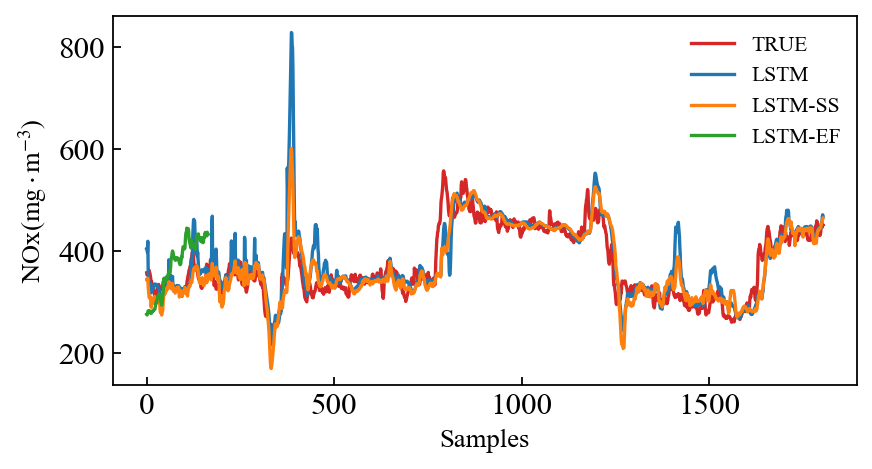

In [581]:
## 画图
## 画图
config = {
"font.family":"times new roman",    
"font.size": 14,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
    
"ytick.direction":"in",
}
rcParams.update(config)

h = 14
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
plt.figure(dpi=160, figsize=(6,3))
plt.plot(y_true1[:,h],color = color_list[4],linewidth=1.5)
plt.plot(y_pred1[:,h],color = color_list[0],linewidth=1.5)
plt.plot(y_pred3[:,h],color = color_list[2],linewidth=1.5)
plt.plot(y_pred2[:,h],color = color_list[3],linewidth=1.5)

plt.xlabel("Samples",{"size":12})
plt.ylabel("NOx($\mathrm{mg \cdot m^{-3}}$)",{"size":12})
plt.legend(['TRUE', 'LSTM', 'LSTM-SS','LSTM-EF'],frameon=False, fontsize = 'x-small',bbox_to_anchor=(1.005, 1) )

### LOSS画图

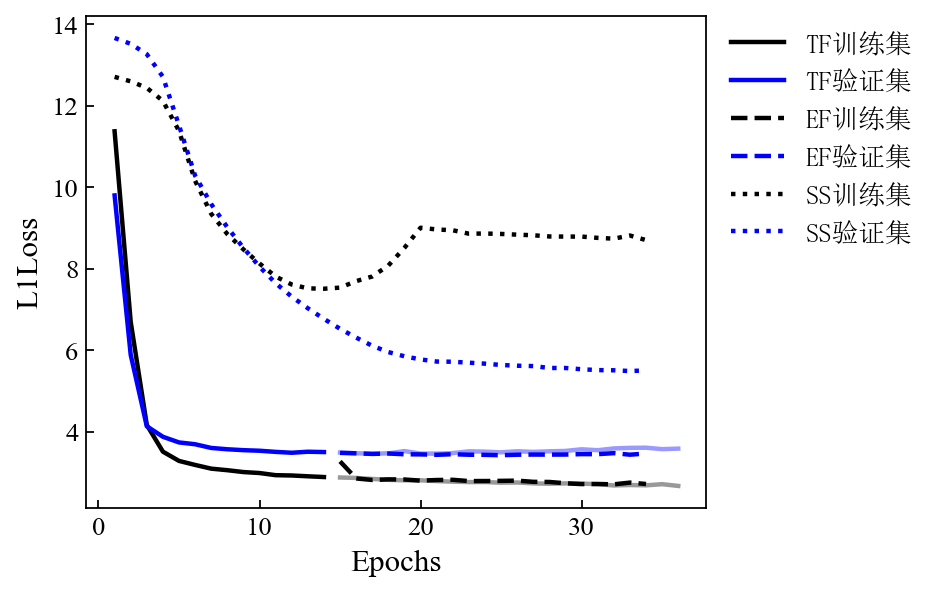

In [42]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

train_loss = torch.load("loss/DeepAR_train_loss.pt")
val_loss = torch.load("loss/DeepAR_val_loss.pt")

re_train_loss = torch.load("loss/DeepAR_re_train_loss.pt")
re_val_loss = torch.load("loss/DeepAR_re_val_loss.pt")

ss_train_loss = torch.load("loss/DeepAR_ss_train_loss.pt")
ss_val_loss = torch.load("loss/DeepAR_ss_val_loss.pt")

config = {
"font.family":'serif',  
"font.size": 12,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)

plt.figure(dpi=160, figsize=(5,4))
plt.plot(np.arange(1, len(train_loss)+1)[0:14], train_loss[0:14], 'k',linewidth=2.0)
plt.plot(np.arange(1, len(val_loss)+1)[0:14], val_loss[0:14], 'b',linewidth=2.0)

plt.plot(np.arange(15, 15+len(re_train_loss)), re_train_loss, 'k',linestyle='--', linewidth=2.0)
plt.plot(np.arange(15, 15+len(re_val_loss)), re_val_loss, 'b',linestyle='--', linewidth=2.0)

plt.plot(np.arange(1, len(ss_train_loss)+1), ss_train_loss, 'k',linestyle=':', linewidth=2.0)
plt.plot(np.arange(1, len(ss_val_loss)+1), ss_val_loss, 'b',linestyle=':',linewidth=2.0)

plt.plot(np.arange(1, len(train_loss)+1)[14:], train_loss[14:], 'k',linewidth=2.0, alpha = 0.4)
plt.plot(np.arange(1, len(val_loss)+1)[14:], val_loss[14:], 'b',linewidth=2.0, alpha = 0.4)

plt.xlabel("Epochs",{"size":14})
plt.ylabel("L1Loss",{"size":14})
legend_font = {"family" : "serif"}
plt.legend(['TF训练集', 'TF验证集', 'EF训练集','EF验证集','SS训练集','SS验证集'],frameon=False, prop=legend_font, fontsize = 10, bbox_to_anchor=(1.001, 1.02))

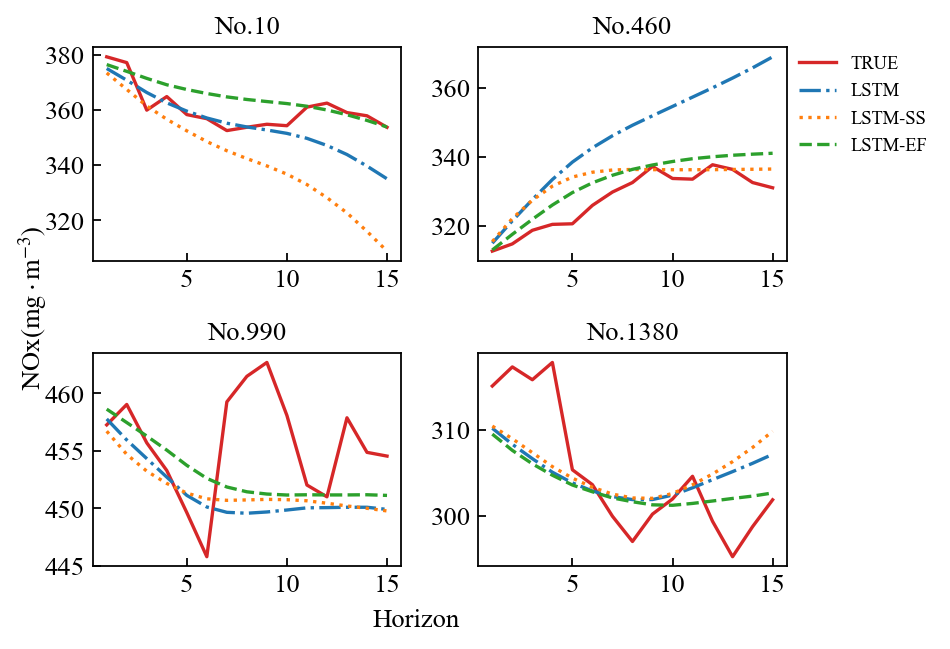

In [588]:
config = {
"font.family":'serif',  
"font.size": 12,       #14 放大是16
"mathtext.fontset":'stix',
"xtick.direction":"in",
"ytick.direction":"in",
#"font.serif": ['SimSun'],
"font.family":"times new roman",
}
rcParams.update(config)
color_list = plt.cm.tab10(np.linspace(0, 1, 12))
x = np.arange(1,16)
fig, ax1 = plt.subplots(2,2, figsize=(5,4), dpi=160)


point = 10
ax1[0,0].plot(x, y_true1[point-1,:], color=color_list[4], linestyle='-', linewidth=1.5)
ax1[0,0].plot(x, y_pred1[point-1,:], color=color_list[0], linestyle='-.', linewidth=1.5)
ax1[0,0].plot(x, y_pred3[point-1,:], color=color_list[2], linestyle=':', linewidth=1.5)
ax1[0,0].plot(x, y_pred2[point-1,:], color=color_list[3], linestyle='--', linewidth=1.5)
ax1[0,0].set_title('No.10', size=12)


point = 460
ax1[0,1].plot(x, y_true1[point-1,:], color=color_list[4], linestyle='-', linewidth=1.5)
ax1[0,1].plot(x, y_pred1[point-1,:], color=color_list[0], linestyle='-.', linewidth=1.5)
ax1[0,1].plot(x, y_pred3[point-1,:], color=color_list[2], linestyle=':', linewidth=1.5)
ax1[0,1].plot(x, y_pred2[point-1,:], color=color_list[3], linestyle='--', linewidth=1.5)
ax1[0,1].set_title('No.460', size=12)

point = 987
ax1[1,0].plot(x, y_true1[point-1,:], color=color_list[4], linestyle='-', linewidth=1.5)
ax1[1,0].plot(x, y_pred1[point-1,:], color=color_list[0], linestyle='-.', linewidth=1.5)
ax1[1,0].plot(x, y_pred3[point-1,:], color=color_list[2], linestyle=':', linewidth=1.5)
ax1[1,0].plot(x, y_pred2[point-1,:], color=color_list[3], linestyle='--', linewidth=1.5)
ax1[1,0].set_title('No.990', size=12)

point = 1380
ax1[1,1].plot(x, y_true1[point-1,:], color=color_list[4], linestyle='-', linewidth=1.5)
ax1[1,1].plot(x, y_pred1[point-1,:], color=color_list[0], linestyle='-.', linewidth=1.5)
ax1[1,1].plot(x, y_pred3[point-1,:], color=color_list[2], linestyle=':', linewidth=1.5)
ax1[1,1].plot(x, y_pred2[point-1,:], color=color_list[3], linestyle='--', linewidth=1.5)
ax1[1,1].set_title('No.1380', size=12)


egend_font = {"family" : "serif"}
fig.legend(['TRUE', 'LSTM', 'LSTM-SS','LSTM-EF'],frameon=False,\
           fontsize='x-small', bbox_to_anchor=(1.16, 0.92))

fig.text(0.5, 0, "Horizon",size=12, ha='center')
fig.text(0, 0.5, "NOx($\mathrm{mg \cdot m^{-3}}$)",size=12, va='center', rotation='vertical')   
plt.tight_layout()